In [1]:
import numpy as np
import time
from ds1054z import DS1054Z
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.signal import blackmanharris
from matplotlib.ticker import EngFormatter

scope = DS1054Z('192.168.1.252')
print(scope.idn)

RIGOL TECHNOLOGIES,DS1054Z,DS1ZA192409533,00.04.04.SP3


In [2]:
scope.single()
time.sleep(1)
V = scope.get_waveform_samples(1)
Ts = scope.waveform_time_values

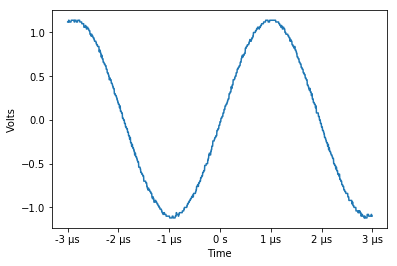

In [3]:
fig, ax = plt.subplots()
ax.plot(Ts,V) 
formatter = EngFormatter(unit='s')
ax.xaxis.set_major_formatter(formatter)
plt.xlabel('Time')
plt.ylabel('Volts')
plt.show()

In [4]:
scale = scope.timebase_scale
scope.timebase_scale = scale*100
if(not scope.running):
    scope.run()
time.sleep(1)
scope.memory_depth = 120e3
time.sleep(1)
scope.single()
time.sleep(1)
V2 = scope.get_waveform_samples(1,mode='MAX')
Ts2 = scope.waveform_time_values
scope.timebase_scale = scale
scope.single()

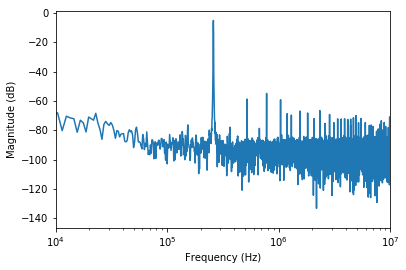

In [5]:
Fs=1/(Ts2[1]-Ts2[0])
fig, ax = plt.subplots()
ax.magnitude_spectrum(V2,Fs=Fs,scale='dB') 
formatter = EngFormatter(unit='Hz')
ax.xaxis.set_major_formatter(formatter)
ax.set_xscale('log')
plt.xlim(1e4,1e7)
plt.xlabel('Frequency (Hz)')
plt.show()

In [6]:
"""
This is cell is abased on endolith's Python implementation of a THD+N analysis.
Original code can be found here: https://gist.github.com/endolith/246092
"""
def rms_flat(a):
    """
    Return the root mean square of all the elements of *a*, flattened out.
    """
    return np.sqrt(np.mean(np.absolute(a)**2))

def find_range(f, x):
    """
    Find range between nearest local minima from peak at index x
    """
    for i in np.arange(x+1, len(f)):
        if f[i+1] >= f[i]:
            uppermin = i
            break
    for i in np.arange(x-1, 0, -1):
        if f[i] <= f[i-1]:
            lowermin = i + 1
            break
    return (lowermin, uppermin)

def THDN(signal, sample_rate):
    """
    Measure the THD+N for a signal and print the results
    Prints the estimated fundamental frequency and the measured THD+N.  This is
    calculated from the ratio of the entire signal before and after
    notch-filtering.
    Currently this tries to find the "skirt" around the fundamental and notch
    out the entire thing.  A fixed-width filter would probably be just as good,
    if not better.
    """
    # Get rid of DC and window the signal

    # TODO: Do this in the frequency domain, and take any skirts with it?
    signal -= np.mean(signal)
    windowed = signal * blackmanharris(len(signal))  # TODO Kaiser?

    # Measure the total signal before filtering but after windowing
    total_rms = rms_flat(windowed)

    # Find the peak of the frequency spectrum (fundamental frequency), and
    # filter the signal by throwing away values between the nearest local
    # minima
    f = np.fft.rfft(windowed)
    i = np.argmax(abs(f))

    # Not exact
    print('Frequency: %f Hz' % (sample_rate * (i / len(windowed))))
    lowermin, uppermin = find_range(abs(f), i)
    f[lowermin: uppermin] = 0

    # Transform noise back into the signal domain and measure it
    # TODO: Could probably calculate the RMS directly in the frequency domain
    # instead
    noise = np.fft.irfft(f)
    THDN = rms_flat(noise) / total_rms
    print("THD+N:     %.4f%% or %.1f dB" % (THDN * 100, 20 * np.log10(THDN)))
    
THDN(V2,Fs)

Frequency: 259375.000000 Hz
THD+N:     1.1097% or -39.1 dB
